In [ ]:
import pandas as pd
from osgeo import gdal
from pyproj import CRS, Transformer
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Study area and used map data

The study area is located in the vicinity of Evo, Finland, and consists of x map sheets. From each map sheet, we have two different historical scanned maps, older from 1965 and newer from either 1984 or 1985. The maps were provided by [National Land Survey of Finland](https://www.maanmittauslaitos.fi/en/e-services/old-printed-maps), and the ground control points for each individual map were acquired from [vanhatkartat.fi](https://vanhatkartat.fi) by Shingle Oy. 

# Cropping

As the maps contain a lot of unnecessary information, such as ticks for coordinates and legend for map symbols, first step is to crop the maps to contain only the relevant information and adjust the GCPs accordingly.

In [ ]:
map_path = Path('../data/maps/raw_maps/')
gcp_path = Path('../data/gcps/raw/')
map_files = [f for f in os.listdir(map_path) if f.endswith('jpg')]

Scanned old maps look like this:

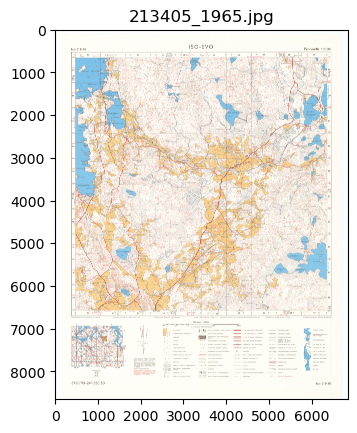

In [ ]:
ex_file = map_files[0]
ex_im = cv2.imread(str(map_path/ex_file))
ex_im = cv2.cvtColor(ex_im, cv2.COLOR_BGR2RGB)
plt.imshow(ex_im)
plt.title(ex_file)
plt.show()

And the corresponding ground control points (GCPs) are saved in this format:

In [ ]:
points = pd.read_csv(gcp_path/f'{ex_file}.points')
points.head()

,mapX,mapY,pixelX,pixelY,enable
0,24.927086,61.215496,477,670,1
1,25.113131,61.214096,6356,666,1
2,25.109974,61.124372,6364,6571,1
3,24.924457,61.125767,483,6574,1


At this point, we also adjust the white balance for all of the maps, as it varies a lot. As the reference white patch, we used 50x50 pixel patch outside the map contents.

In [ ]:
patches_65 = []
patches_80s = []
for r in map_files:
    m = cv2.imread(str(map_path/r))
    points = pd.read_csv(gcp_path/f'{r}.points')
    if '1965' in r:
        patch = m[int(points.iloc[3].pixelY-250):int(points.iloc[3].pixelY-200), 
                  int(points.iloc[3].pixelX-250):int(points.iloc[3].pixelX-200)]
        patches_65.append(patch)
    else:
        patch = m[int(points.iloc[3].pixelY-250):int(points.iloc[3].pixelY-200), 
                  int(points.iloc[3].pixelX-175):int(points.iloc[3].pixelX-125)]
        patches_80s.append(patch)

To visualize how much the maps vary between sheets, the white reference patches look like this. Without any wear, each of these patches should be white.

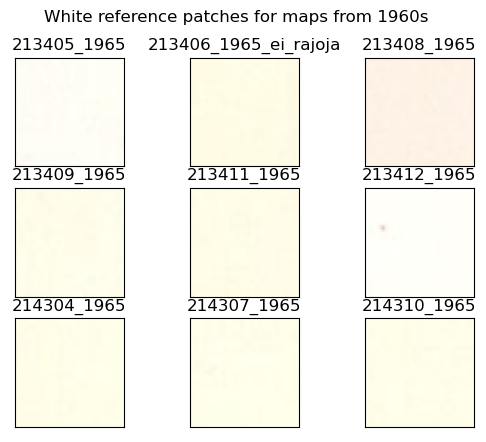

In [ ]:
fig, axs = plt.subplots(3,3)

for p, a, fname in zip(patches_65, axs.flatten(), map_files[::2]):
    a.set_xticks([])
    a.set_yticks([])
    a.imshow(cv2.cvtColor(p, cv2.COLOR_BGR2RGB))
    a.set_title(fname[:-4])
    
plt.suptitle('White reference patches for maps from 1960s')
plt.show()

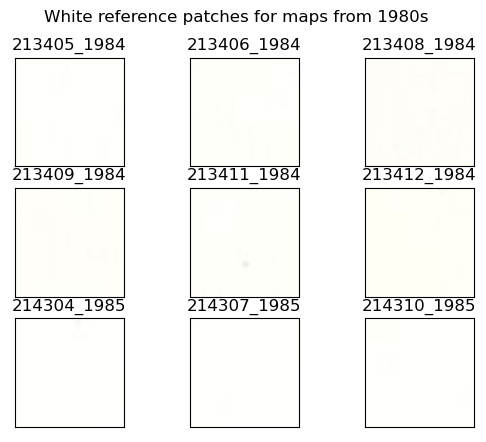

In [ ]:
fig, axs = plt.subplots(3,3)

for p, a, fname in zip(patches_80s, axs.flatten(), map_files[1::2]):
    a.set_xticks([])
    a.set_yticks([])
    a.imshow(cv2.cvtColor(p, cv2.COLOR_BGR2RGB))
    a.set_title(fname[:-4])
    
plt.suptitle('White reference patches for maps from 1980s')
plt.show()

White balance is adjusted with the following formula, where `ref_white` is the mean value of the corresponding patch.

In [ ]:
def white_balance(im, ref_white):
    lum = sum(ref_white) / 3
    r = im[...,2] * lum / ref_white[2]
    g = im[...,1] * lum / ref_white[1]
    b = im[...,0] * lum / ref_white[0]
    r = np.clip(r, 0, 255)
    g = np.clip(g, 0, 255)
    b = np.clip(b, 0, 255)
    return np.dstack([b,g,r]).astype(np.uint8)

In [ ]:
cropped_gcp_path = Path('../data/gcps/cropped/')
cropped_map_path = Path('../data/maps/cropped_maps/')
for m in map_files:
    im = cv2.imread(str(map_path/m))
    
    points = pd.read_csv(gcp_path/f'{m}.points')
    xmin = points.pixelX.min()
    xmax = points.pixelX.max()
    ymin = points.pixelY.min()
    ymax = points.pixelY.max()
    new_points = points.copy()
    new_points.loc[0, 'pixelX'] = max(0, new_points.iloc[0]['pixelX'] - xmin)
    new_points.loc[0, 'pixelY'] = max(0, new_points.iloc[0]['pixelY'] - ymin)
    new_points.loc[1, 'pixelX'] = min(xmax-xmin, new_points.iloc[1]['pixelX']-xmin)
    new_points.loc[1, 'pixelY'] = max(0, new_points.iloc[1]['pixelY'] - ymin)
    new_points.loc[2, 'pixelX'] = min(xmax-xmin, new_points.iloc[2]['pixelX']-xmin)
    new_points.loc[2, 'pixelY'] = min(ymax-ymin, new_points.iloc[2]['pixelY']-ymin)
    new_points.loc[3, 'pixelX'] = max(0, new_points.iloc[3]['pixelX'] - xmin)
    new_points.loc[3, 'pixelY'] = min(ymax-ymin, new_points.iloc[3]['pixelY']-ymin)
    new_points.to_csv(cropped_gcp_path/f'{m}.points', index=False)
    
    if '1965' in r:
        patch = im[int(points.iloc[3].pixelY-250):int(points.iloc[3].pixelY-200), 
                   int(points.iloc[3].pixelX-250):int(points.iloc[3].pixelX-200)]
    else:
        patch = im[int(points.iloc[3].pixelY-250):int(points.iloc[3].pixelY-200), 
                   int(points.iloc[3].pixelX-175):int(points.iloc[3].pixelX-125)]
    
    cropped_map = im[ymin:ymax, xmin:xmax]
    cropped_map = white_balance(cropped_map, patch.mean(axis=(0,1)))
    cv2.imwrite(str(cropped_map_path/m), cropped_map)

After cropping only the relevant area remains, and all maps have more or less similar color balance.

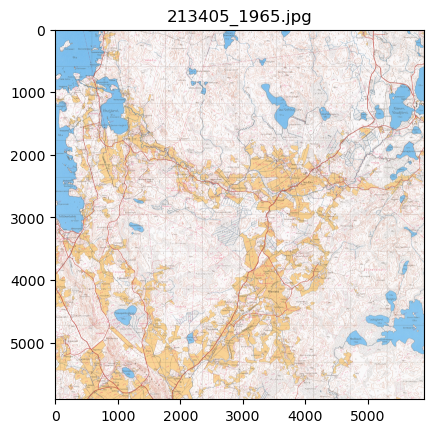

In [ ]:
cropped_ex = cv2.imread(str(cropped_map_path/ex_file))
cropped_ex = cv2.cvtColor(cropped_ex, cv2.COLOR_BGR2RGB)
plt.imshow(cropped_ex)
plt.title(ex_file)
plt.show()

And the GCPs are adjusted.

In [ ]:
cropped_points = pd.read_csv(cropped_gcp_path/f'{ex_file}.points')
cropped_points.head()

,mapX,mapY,pixelX,pixelY,enable
0,24.927086,61.215496,0,4,1
1,25.113131,61.214096,5879,0,1
2,25.109974,61.124372,5887,5905,1
3,24.924457,61.125767,6,5908,1


# Georeferencing

After cropping, the maps are aligned and converted to `EPSG:3067` coordinates, as it is closest to the original map CRS. GCPs are in `EPSG:4326`, so they need to be converted first.

In [ ]:
aligned_map_outpath = Path('../data/maps/aligned_maps/')

in_crs = CRS('EPSG:4326')
out_crs = CRS('EPSG:3067')
transformer = Transformer.from_crs(in_crs, out_crs, always_xy=True)

for m in map_files:
    gcp_list = []
    new_points = pd.read_csv(cropped_gcp_path/f'{m}.points')
    
    for row in new_points.itertuples():
        tfmd_x, tfmd_y = transformer.transform(row.mapX, row.mapY)
        gcp_list.append(gdal.GCP(tfmd_x, tfmd_y, 1, row.pixelX, row.pixelY))
        
    translate_kwargs = {
        'GCPs': gcp_list,
        'format': 'GTIFF',
        'bandList': [1,2,3]
    }
    
    out_fname = m.replace('jpg', 'tif')
    gdal.Translate(str(aligned_map_outpath/out_fname), str(cropped_map_path/m), **translate_kwargs)
    gdal.Warp(str(aligned_map_outpath/out_fname), str(aligned_map_outpath/out_fname),
              options='-r near -tps -co COMPRESS=LZW -t_srs EPSG:3067')

Final results are georeferenced RGB images in `EPSG:3067` coordinates, which then look like this.

In [ ]:
import rasterio as rio
import rasterio.plot as rioplot

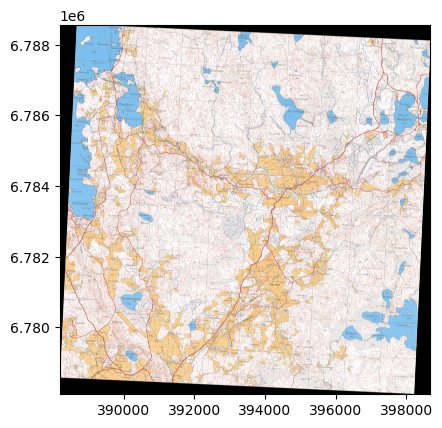

<AxesSubplot:>

In [ ]:
src = rio.open(aligned_map_outpath/ex_file.replace('jpg', 'tif'))
rioplot.show(src)